# Informations sur la base de données.

#### Buts de l'analyse

#### Étapes de traitement des données

#### Importation des librairies utilisées.

In [1]:
import os

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import scipy.stats as stats

%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Pour la reproductibilité des résultats
np.random.seed(43)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

# some nice colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

sns.set(rc={'figure.figsize':(9, 4)})
sns.set_theme(context="notebook", style="white", palette="Set2")

## Recommandations 

### Analyse des forme


* **Ligne et colonne: (6498063, 7)**

niveau de detail, une ligne par :
                  Géographie, 
                  Classification nationale des professions(CNP4),
                  Sexe,
                  Durée de l'emploi,	
                  Période de référence, mensuelle

* **Type de variables: 2 variables de type numérique et 5 variables qualitative.**

    * Géographie : Canada, Province ou territoire
    * Classification nationale des professions(CNP4)
    * Sexe
    * Mois: nombre moyenne de la durée d'emploi
    * Personnes : le nombre des personnes 
    * Période de référence : mensuelle

La repartition des individus est egale pour toutes les modalites des variables Sexe, CNP, Géographie,.Périoade de référence 

* La variable Regions contient 11 modalites
* La variable CNP contient 51 modalites
* La variable Sexe contienttient 3 modaliteses
* La variable Durée de l'emploi contient 9 modalites
* La variable Année/Mois contient 429 modalites


    
* **Valeurs extremes **

On va supposer, pour l'exemple, que la base de données contient 0,5% de valeurs aberrantes de toutes sortes. Ce n'est pas exagéré. Cela représente $0,005*168300 \approx 841$ valeurs.

On utilise la méthode de la [forêt d'isolation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) pour détecter et éliminer un maximum de 0,5% des valeurs possiblement aberrantes.  
    
### Analyse de structure

* Conserver seulement les variables :  
    * Géographie : Canada, Province ou territoire,
    * Classification nationale des professions(CNP4)
    * Sexe
    * Personnes
    * Duree moyenne d'emploi
    * Période de référence : annuelle


### Nettoyage des donnees: Recommandations

* Filtrer la modalite "Les deux sexes" de la variable **Sexe**
* Filtrer la modalite "'Canada'" de la variable **Region**
* Agreger l'information pour avoir une fréquence annuelle 
* Plage temporelle : 1997-2021



# Partie I: Prétraitement des données.

## Lecture des bases de données en format CSV.

Les données sont écrites dans un DataFrame de la librairie Pandas.

In [3]:
cwd=r"D:\Daiana\Documents\AEC Intelligence artificielle\Mise en place d'un écosystème d'IA\salary\data\interim\duree_emploi_CNP"

In [4]:
def load_db():
    duree_emploi_CNP=pd.read_csv(cwd,sep=",")
    return duree_emploi_CNP#,postes_vacants_CNP,caractéristiques_population_active,heures_habituellement_travaille,heures_effectivement_travaille,personnes_avec_plus_un_emploi,raison_quitter_emploi,absence_travail_temps_plein

In [5]:
duree_emploi_CNP=load_db()

## Explorer les données

In [6]:
duree_emploi_CNP.head()

,Annee/Mois,Regions,CNP,Sexe,Durée de l'emploi,Mois,Personnes
0,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,1 à 3 mois,NaN,14.1
1,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,121 à 240 mois,NaN,19.7
2,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,13 à 60 mois,NaN,53.4
3,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,241 mois ou plus,NaN,7.1
4,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,4 à 6 mois,NaN,12.4


In [7]:
duree_emploi_CNP.tail()

,Annee/Mois,Regions,CNP,Sexe,Durée de l'emploi,Mois,Personnes
6498058,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,4 à 6 mois,NaN,2.9
6498059,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,61 à 120 mois,NaN,1.8
6498060,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,7 à 12 mois,NaN,1.6
6498061,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,Durée moyenne,83.8,NaN
6498062,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,"Emploi total, tous les mois",NaN,16.5


### Dimensions du dataset

In [8]:
print("Les dimensions du jeux des donnees: ", duree_emploi_CNP.shape)
print() 

Les dimensions du jeux des donnees:  (6498063, 7)



In [9]:
# Size of our data set
## le nombre de lignes multiplié par le nombre de colonnes si DataFrame.
print("Nombre d’éléments:", duree_emploi_CNP.size)
print()

Nombre d’éléments: 45486441



Le nombre d'individus est égale à 6498063 et le nombre de descripteurs est égale à 7

### Type des donnees

In [10]:
duree_emploi_CNP.dtypes

Annee/Mois            object
Regions               object
CNP                   object
Sexe                  object
Durée de l'emploi     object
Mois                 float64
Personnes            float64
dtype: object

In [11]:
duree_emploi_CNP.dtypes.value_counts()

object     5
float64    2
dtype: int64

Le jeu des données a 2 variables de type numérique et 5 variables qualitative.

In [12]:
duree_emploi_CNP.describe()

,Mois,Personnes
count,722007.000000,5.776056e+06
mean,95.811712,2.788090e+01
std,42.514423,2.198379e+02
min,0.000000,0.000000e+00
25%,70.100000,0.000000e+00
50%,95.500000,2.000000e+00
75%,119.500000,1.020000e+01
max,474.000000,1.996600e+04


In [13]:
duree_emploi_CNP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6498063 entries, 0 to 6498062
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Annee/Mois         object 
 1   Regions            object 
 2   CNP                object 
 3   Sexe               object 
 4   Durée de l'emploi  object 
 5   Mois               float64
 6   Personnes          float64
dtypes: float64(2), object(5)
memory usage: 347.0+ MB


### Affichage du nombre de valeurs manquantes Nans dans le DataFrame.

In [14]:
duree_emploi_CNP.isna().sum()

Annee/Mois                 0
Regions                    0
CNP                        0
Sexe                       0
Durée de l'emploi          0
Mois                 5776056
Personnes             722007
dtype: int64

In [15]:
duree_emploi_CNP[duree_emploi_CNP.Mois.notnull()]["Durée de l'emploi"].value_counts()

Durée moyenne    722007
Name: Durée de l'emploi, dtype: int64

In [20]:
duree_emploi_CNP[duree_emploi_CNP.Mois.notnull()]

,Annee/Mois,Regions,CNP,Sexe,Durée de l'emploi,Mois,Personnes
7,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,Durée moyenne,66.4,NaN
16,1987-01,Alberta,"Affaires, finance et administration [1]",Hommes,Durée moyenne,88.7,NaN
25,1987-01,Alberta,"Affaires, finance et administration [1]",Les deux sexes,Durée moyenne,72.3,NaN
34,1987-01,Alberta,"Arts, culture, sports et loisirs [5]",Femmes,Durée moyenne,42.6,NaN
43,1987-01,Alberta,"Arts, culture, sports et loisirs [5]",Hommes,Durée moyenne,86.8,NaN
...,...,...,...,...,...,...,...
6498025,2022-09,Île-du-Prince-Édouard,Superviseurs/superviseures et métiers techniqu...,Hommes,Durée moyenne,170.1,NaN
6498034,2022-09,Île-du-Prince-Édouard,Superviseurs/superviseures et métiers techniqu...,Les deux sexes,Durée moyenne,182.0,NaN
6498043,2022-09,Île-du-Prince-Édouard,Vente et services [6],Femmes,Durée moyenne,77.6,NaN
6498052,2022-09,Île-du-Prince-Édouard,Vente et services [6],Hommes,Durée moyenne,92.7,NaN


### Pivoter la Duree de l emploi

In [21]:

df1_=duree_emploi_CNP[duree_emploi_CNP.Mois.notnull()][["Annee/Mois","Regions","CNP","Sexe","Durée de l'emploi","Mois"]].set_index(["Annee/Mois","Regions","CNP","Sexe"])

In [22]:
df1_.columns

Index(['Durée de l'emploi', 'Mois'], dtype='object')

In [23]:
duree_emploi_CNP[duree_emploi_CNP.Mois.isnull()]["Durée de l'emploi"].value_counts()

1 à 3 mois                     722007
121 à 240 mois                 722007
13 à 60 mois                   722007
241 mois ou plus               722007
4 à 6 mois                     722007
61 à 120 mois                  722007
7 à 12 mois                    722007
Emploi total, tous les mois    722007
Name: Durée de l'emploi, dtype: int64

In [25]:
df2_=duree_emploi_CNP[duree_emploi_CNP.Mois.isnull()][["Annee/Mois","Regions","CNP","Sexe","Durée de l'emploi","Personnes"]].set_index(["Annee/Mois","Regions","CNP","Sexe"])

In [26]:
df2_

Durée de l'emploi  \
Annee/Mois Regions               CNP                                     Sexe                                          
1987-01    Alberta               Affaires, finance et administration [1] Femmes                           1 à 3 mois   
                                                                         Femmes                       121 à 240 mois   
                                                                         Femmes                         13 à 60 mois   
                                                                         Femmes                     241 mois ou plus   
                                                                         Femmes                           4 à 6 mois   
...                                                                                                              ...   
2022-09    Île-du-Prince-Édouard Vente et services [6]                   Les deux sexes             241 mois ou plus   
                                                                         Les deux sexes                   4 à 6 mois   
                                                                         Les deux sexes                61 à 120 mois   
                                                                         Les deux sexes                  7 à 12 mois   
                                                                         Les deux sexes  Emploi total, tous les mois   

                                                                                         Personnes  
Annee/Mois Regions               CNP                                     Sexe                       
1987-01    Alberta               Affaires, finance et administration [1] Femmes               14.1  
                                                                         Femmes               19.7  
                                                                         Femmes               53.4  
                                                                         Femmes                7.1  
                                                                         Femmes               12.4  
...                                                                                            ...  
2022-09    Île-du-Prince-Édouard Vente et services [6]                   Les deux sexes        2.6  
                                                                         Les deux sexes        2.9  
                                                                         Les deux sexes        1.8  
                                                                         Les deux sexes        1.6  
                                                                         Les deux sexes       16.5  

[5776056 rows x 2 columns]

In [27]:
duree_emploi_CNP_=df1_.merge(df2_,how="inner",left_index=True, right_index=True).reset_index()

In [28]:
duree_emploi_CNP_

,Annee/Mois,Regions,CNP,Sexe,Durée de l'emploi_x,Mois,Durée de l'emploi_y,Personnes
0,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,Durée moyenne,66.4,1 à 3 mois,14.1
1,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,Durée moyenne,66.4,121 à 240 mois,19.7
2,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,Durée moyenne,66.4,13 à 60 mois,53.4
3,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,Durée moyenne,66.4,241 mois ou plus,7.1
4,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,Durée moyenne,66.4,4 à 6 mois,12.4
...,...,...,...,...,...,...,...,...
5776051,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,Durée moyenne,83.8,241 mois ou plus,2.6
5776052,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,Durée moyenne,83.8,4 à 6 mois,2.9
5776053,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,Durée moyenne,83.8,61 à 120 mois,1.8
5776054,2022-09,Île-du-Prince-Édouard,Vente et services [6],Les deux sexes,Durée moyenne,83.8,7 à 12 mois,1.6


In [29]:
duree_emploi_CNP_.rename(columns={"Mois":"Duree moyenne emploi","Durée de l'emploi_y":"Durée de l'emploi"},inplace=True)

In [30]:
duree_emploi_CNP_=duree_emploi_CNP_.drop("Durée de l'emploi_x",axis=1)

In [31]:
duree_emploi_CNP_.shape

(5776056, 7)

### Analyse caractéristiques catégorielles

#### Séparer les données en colonnes numériques et catégorielle

In [32]:
cat_col=[]
num_col=[]

for col in duree_emploi_CNP_.columns:
    if duree_emploi_CNP_[col].dtypes=="object":
        cat_col.append(col)
    else:
        num_col.append(col)
print ("Variable catégorielle:",cat_col)
print("Variable numériques:",num_col)

Variable catégorielle: ['Annee/Mois', 'Regions', 'CNP', 'Sexe', "Durée de l'emploi"]
Variable numériques: ['Duree moyenne emploi', 'Personnes']


#### Nombre valeurs uniques

In [33]:
for col in cat_col:
    print(col,'({})'.format(duree_emploi_CNP_[col].nunique()),":")
    print(duree_emploi_CNP_[col].value_counts())
    print()
    print()

Annee/Mois (429) :
1987-01    13464
2011-08    13464
2011-06    13464
2011-05    13464
2011-04    13464
           ...  
1998-09    13464
1998-08    13464
1998-07    13464
1998-06    13464
2022-09    13464
Name: Annee/Mois, Length: 429, dtype: int64


Regions (11) :
Alberta                    525096
Canada                     525096
Colombie-Britannique       525096
Manitoba                   525096
Nouveau-Brunswick          525096
Nouvelle-Écosse            525096
Ontario                    525096
Québec                     525096
Saskatchewan               525096
Terre-Neuve-et-Labrador    525096
Île-du-Prince-Édouard      525096
Name: Regions, dtype: int64


CNP (51) :
Affaires, finance et administration [1]                                                                                                                           113256
Personnel professionnel en gestion des affaires et en finance [11]                                                                                   

* La variable Regions contient 11 modalites
* La variable CNP contient 51 modalites
* La variable Sexe contienttient 3 modaliteses
* La variable Durée de l'emploi contient 9 modalites
* La variable Année/Mois contient 429 modalites


Note: La répartition des données est égale pour toutes les modalités de chaque catégories

### Analyse caractéristiques numériques

In [34]:
duree_emploi_CNP_.describe()

,Duree moyenne emploi,Personnes
count,5.776056e+06,5.776056e+06
mean,9.581171e+01,2.788090e+01
std,4.251440e+01,2.198379e+02
min,0.000000e+00,0.000000e+00
25%,7.010000e+01,0.000000e+00
50%,9.550000e+01,2.000000e+00
75%,1.195000e+02,1.020000e+01
max,4.740000e+02,1.996600e+04


La durée moyenne de travail est de 96 mois (~ 8 ans).
Au moins 75% des personnes ont travailler 119.5 mois (~ 10 ans)

In [35]:
duree_emploi_CNP_0=duree_emploi_CNP_[duree_emploi_CNP_["Duree moyenne emploi"]==0.0]

In [36]:
(duree_emploi_CNP_[duree_emploi_CNP_["Duree moyenne emploi"]==0.0].shape[0]/duree_emploi_CNP_.shape[0])*100

3.9332028636841474

Il y a 4% (227.184) occurences dont les variables duree moyenne emploi, et personnes ont la valeur 0.0 

In [38]:
def process_date(dg):
    return pd.DataFrame([[
                        dg["Personnes"].sum(),
                        dg["Duree moyenne emploi"].mean(),
                        ]], columns=["Personnes", "Duree moyenne emploi"])

duree_emploi_CNP_0.groupby(["Regions","CNP","Sexe","Durée de l'emploi","Annee/Mois"]).apply(process_date).reset_index(4, drop=True).reset_index(drop=False)

,Regions,CNP,Sexe,Durée de l'emploi,level_4,Personnes,Duree moyenne emploi
0,Alberta,Cadres supérieurs/cadres supérieures [00],Femmes,1 à 3 mois,0,0.0,0.0
1,Alberta,Cadres supérieurs/cadres supérieures [00],Femmes,1 à 3 mois,0,0.0,0.0
2,Alberta,Cadres supérieurs/cadres supérieures [00],Femmes,1 à 3 mois,0,0.0,0.0
3,Alberta,Cadres supérieurs/cadres supérieures [00],Femmes,1 à 3 mois,0,0.0,0.0
4,Alberta,Cadres supérieurs/cadres supérieures [00],Femmes,1 à 3 mois,0,0.0,0.0
...,...,...,...,...,...,...,...
227179,Île-du-Prince-Édouard,Superviseurs/superviseures et métiers techniqu...,Femmes,"Emploi total, tous les mois",0,0.0,0.0
227180,Île-du-Prince-Édouard,Superviseurs/superviseures et métiers techniqu...,Femmes,"Emploi total, tous les mois",0,0.0,0.0
227181,Île-du-Prince-Édouard,Superviseurs/superviseures et métiers techniqu...,Femmes,"Emploi total, tous les mois",0,0.0,0.0
227182,Île-du-Prince-Édouard,Superviseurs/superviseures et métiers techniqu...,Femmes,"Emploi total, tous les mois",0,0.0,0.0


### Agregation par année

In [39]:
duree_emploi_CNP_['Annee'] = duree_emploi_CNP_['Annee/Mois'].str[:4]

In [40]:
duree_emploi_CNP_.head()

,Annee/Mois,Regions,CNP,Sexe,Duree moyenne emploi,Durée de l'emploi,Personnes,Annee
0,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,66.4,1 à 3 mois,14.1,1987
1,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,66.4,121 à 240 mois,19.7,1987
2,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,66.4,13 à 60 mois,53.4,1987
3,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,66.4,241 mois ou plus,7.1,1987
4,1987-01,Alberta,"Affaires, finance et administration [1]",Femmes,66.4,4 à 6 mois,12.4,1987


In [41]:
def process_date(dg):
    return pd.DataFrame([[
                        dg["Personnes"].sum(),
                        dg["Duree moyenne emploi"].mean(),
                        ]], columns=["Personnes", "Duree moyenne emploi"])



In [43]:
df_duree_emploi=duree_emploi_CNP_.groupby(["Regions","CNP","Sexe","Durée de l'emploi","Annee"]).apply(process_date).reset_index(5, drop=True).reset_index(drop=False)

In [44]:
df_duree_emploi.describe()

,Personnes,Duree moyenne emploi
count,484704.000000,484704.000000
mean,332.247406,95.852020
std,2616.941711,38.159629
min,0.000000,0.000000
25%,3.000000,71.850000
50%,23.300000,95.391667
75%,121.300000,118.008333
max,227826.900000,322.808333


## Visualisation des données

Avec les année la difference homme vs femme de la durée d'emploi a diminuer.  

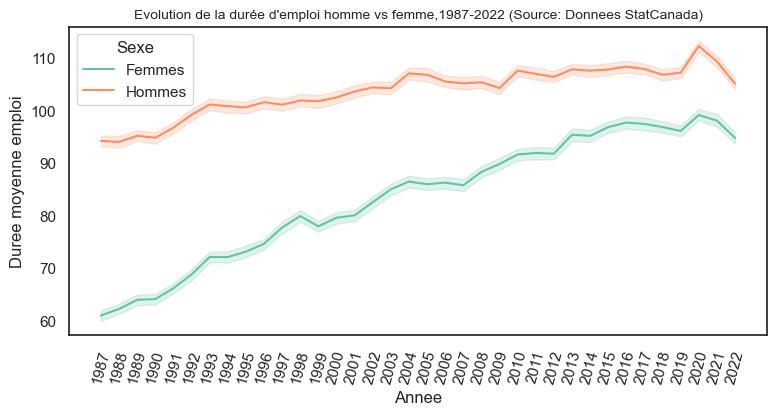

In [45]:
filtre_sexe=df_duree_emploi['Sexe'].isin(['Femmes','Hommes'])
sns.lineplot(data=df_duree_emploi[filtre_sexe], 
             x="Annee", 
             y='Duree moyenne emploi',
             hue='Sexe',
            markers=True,
            dashes=False)
plt.title(label="Evolution de la durée d'emploi homme vs femme,1987-2022 (Source: Donnees StatCanada)",
          fontdict={'fontsize':10}, loc='center')
plt.xticks(rotation=75)
plt.show()

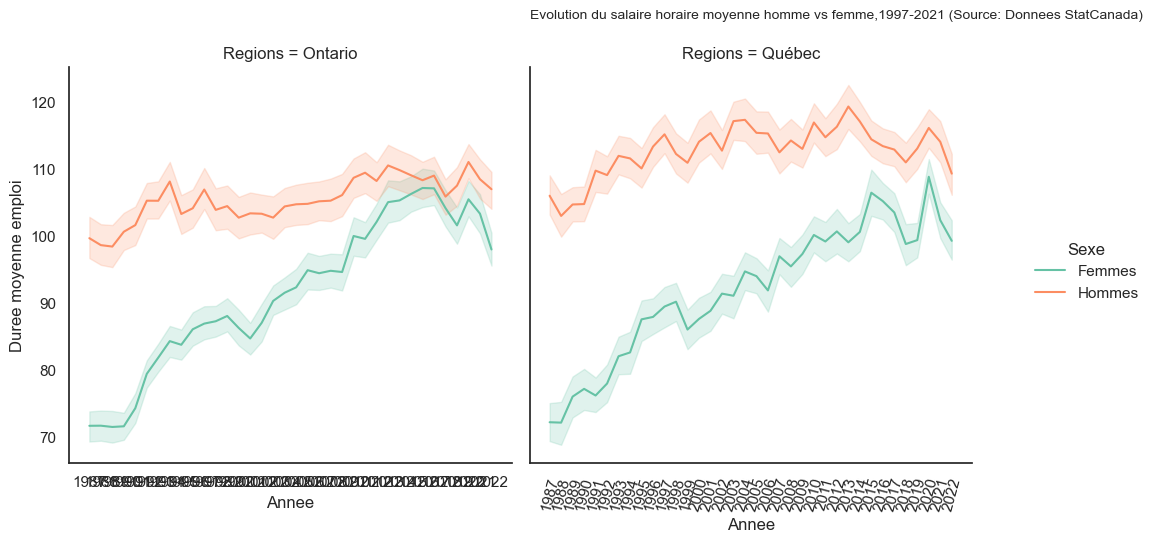

In [48]:
filtre_sexe_Ont_Qc=(df_duree_emploi['Sexe'].isin(['Femmes','Hommes'])) & (df_duree_emploi['Regions'].isin(['Ontario','Québec']))
sns.relplot(data=df_duree_emploi[filtre_sexe_Ont_Qc],
             x="Annee", 
             y='Duree moyenne emploi',
             hue='Sexe',
             col='Regions',
             kind='line',
             #markers=True, 
            dashes=True
            
            )
plt.title(label='Evolution du salaire horaire moyenne homme vs femme,1997-2021 (Source: Donnees StatCanada)',
          fontdict={'fontsize':10}, loc='left',y=1.1)
plt.xticks(rotation=75)
plt.show()

### Distribution des effectifs par region, region /sexe

<Figure size 800x1200 with 0 Axes>

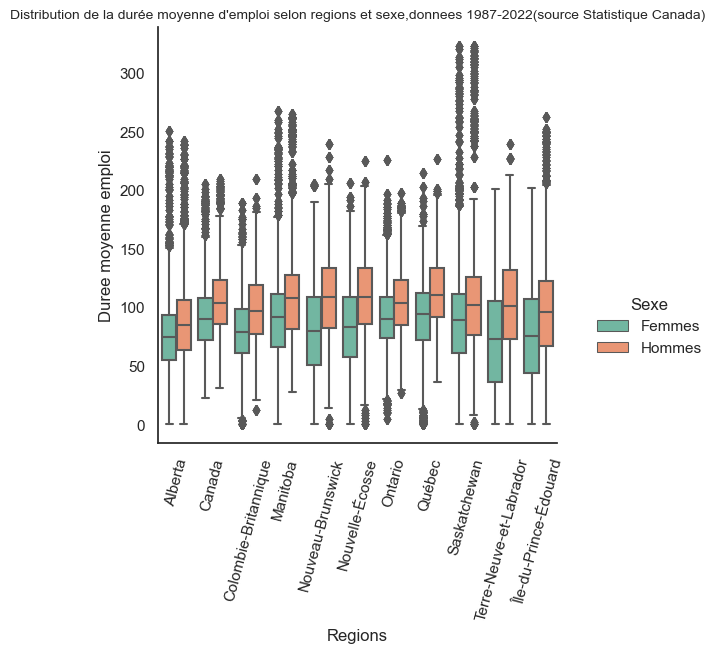

In [53]:
#sal_empl_sexe=salaire_employe_CNP['Sexe'].isin(['Femmes','Hommes'])
filtre_sexe=df_duree_emploi['Sexe'].isin(['Femmes','Hommes'])

plt.figure(figsize=(8,12))
sns.catplot(data=df_duree_emploi[filtre_sexe], x="Regions", 
            y="Duree moyenne emploi", 
            kind="box",
            hue='Sexe',
            #palette="pastel",
           dodge=True)
plt.title(label="Distribution de la durée moyenne d'emploi selon regions et sexe,donnees 1987-2022(source Statistique Canada)",
          fontdict={'fontsize':10}, loc='center')
plt.xticks(rotation=75)
plt.show()

In [54]:
df_duree_emploi.columns

Index(['Regions', 'CNP', 'Sexe', 'Durée de l'emploi', 'Annee', 'Personnes',
       'Duree moyenne emploi'],
      dtype='object')

In [55]:
df_duree_emploi["Durée de l'emploi"].unique()

array(['1 à 3 mois', '121 à 240 mois', '13 à 60 mois', '241 mois ou plus',
       '4 à 6 mois', '61 à 120 mois', '7 à 12 mois',
       'Emploi total, tous les mois'], dtype=object)

## Filtres

* Filtrer la modalite "Les deux sexes" de la variable **Sexe**
* Filtrer la modalite "'Canada'" de la variable **Region**

In [56]:
def filtre_df():
    filtre_sexe=df_duree_emploi.Sexe.isin(["Femmes","Hommes"])
    filtre_region=df_duree_emploi["Regions"]!="Canada"
    filtre_annee=(pd.Series(df_duree_emploi["Annee"]).between("1997","2021"))
    
    df1=df_duree_emploi[filtre_sexe]
    df2=df1[filtre_region]
    df=df2[filtre_annee]
    
    return df

In [57]:
df_duree_emploi=filtre_df()

C:\Users\daian\AppData\Local\Temp\ipykernel_8688\2556160663.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2=df1[filtre_region]
C:\Users\daian\AppData\Local\Temp\ipykernel_8688\2556160663.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df2[filtre_annee]


In [58]:
df_duree_emploi.shape

(204000, 7)

## Exporter to csv

In [60]:
df_duree_emploi.to_csv(r"D:\Daiana\Documents\AEC Intelligence artificielle\Mise en place d'un écosystème d'IA\salary\data\raw\df_duree_emploi", index = False)